# Data Exploration


Also need to think about how to handle the multiple waves per person. Options:
1. Keep all waves (will need to use panel data methods)
2. Keep only one wave per person (will need to decide which wave to keep - most recent? random?)
3. Average across waves (will need to decide how to handle missing data - if a person is missing in one wave but not another, do we keep the non-missing value?)
4. Use only the first wave a person appears in (will lose a lot of data, but will be simpler to analyze)

**Reminder**
- Independent variable = X = informal institutions = nbrsnci_dv = Higher values represent greater cohesion, ranging from 1 “lowest cohesion” to 5 “highest cohesion”.
- Dependent variable = Y = subjective wellbeing = scghq1_dv = Range of scores from 0 (indicating the least amount of distress) to 36 (indicating the greatest amount of distress)

In [1]:
import pandas as pd                                 
from pathlib import Path                           
import matplotlib.pyplot as plt                     
import seaborn as sns                              
import numpy as np                                  
from scipy.stats import norm                        
from sklearn.preprocessing import StandardScaler    
from scipy import stats                             
import statsmodels.api as sm                       
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', None)  # Show all columns when displaying a dataframe
import pyreadstat

In [2]:
# Import file

path = "/Users/arikatz/VSCode Projects/ukhls-informal-institutions-project/data/refinedvariables.dta"
df, meta = pyreadstat.read_dta(path)

print("Shape:", df.shape)
df.head()

Shape: (175335, 18)


,pidp,wave,wave_num,hidp,nbrsnci_dv,gor_dv,urban_dv,sex_dv,age_dv,ethn_dv,marstat_dv,jbstat,fimnnet_dv,fihhmnnet1_dv,houscost1_dv,health,scghq1_dv,hiqual_dv
0,22445,f,6,278664010,3.4,7,1,2,29,1,6,2,2012.000000,NaN,NaN,2,25,3
1,22445,i,9,277344816,3.3,7,1,2,33,1,1,2,1289.699951,1289.699951,1300.0,2,11,3
2,22445,l,12,276637622,1.6,7,1,2,35,1,1,6,145.169998,4146.390137,1350.0,2,32,1
3,29925,f,6,620547610,4.1,7,1,2,37,1,5,1,2175.620117,2175.620117,1451.0,1,11,1
4,29925,i,9,619024416,3.5,7,1,2,40,1,4,2,2904.530029,2904.530029,0.0,1,9,1


In [3]:
# Create a table showing the number of observations in each wave

wave_table = df['wave'].value_counts().sort_index()

display(wave_table)

wave
a    37988
c    40509
f    35472
i    33137
l    28229
Name: count, dtype: int64

Great! For now, I'll just use data from wave C, which has the highest number of observations.

In [4]:
# Drop all waves except wave c

df = df[df['wave'] == 'c']
print("Shape after dropping waves:", df.shape)

Shape after dropping waves: (40509, 18)


## Transforming the explanatory variables

1. Drop all rows with missing values
2. Drop all rows with negative values (i.e. those that indicate "not applicable" or "don't know")
3. Define variables as categorical or continuous, and adjust values accordingly
    - One-hot encode categorical variables
    - Transform binary variables to 0/1
    - Scale continuous variables (standardize to mean 0, sd 1)

Lets start off by identifying which variables are causing the most unusable values

In [5]:
# Calculate % missing and % negative for each column
missing_pct = df.isnull().mean() 
negative_pct = (df.select_dtypes(include=['number']) < 0).mean() * 100   #'number' includes int, float, etc.

# Combine into a summary DataFrame and sort by the sum of % missing and % negative (descending)
summary = pd.DataFrame({
    '% Missing': missing_pct,
    '% Negative': negative_pct
}).fillna(0) # Fill NaN values with 0 for non-numeric columns

summary['% Total'] = summary['% Missing'] + summary['% Negative']
summary = summary.sort_values(by='% Total', ascending=False)

summary.head(10)

,% Missing,% Negative,% Total
hiqual_dv,0.0,0.459157,0.459157
ethn_dv,0.0,0.088869,0.088869
fimnnet_dv,0.0,0.078995,0.078995
fihhmnnet1_dv,0.0,0.029623,0.029623
health,0.0,0.029623,0.029623
gor_dv,0.0,0.017280,0.017280
urban_dv,0.0,0.017280,0.017280
age_dv,0.0,0.002469,0.002469
marstat_dv,0.0,0.002469,0.002469
jbstat,0.0,0.002469,0.002469


This is helpful! It doesn't look like any variables are particularly problematic, so I'll just drop rows with any missing or negative values.

In [6]:
# Record shape before dropping rows with missing or negative values
initial_shape = df.shape

# Drop rows with any missing or negative values
df = df.dropna()
df = df[(df.select_dtypes(include=['number']) >= 0).all(axis=1)]

print("Shape after dropping rows with missing or negative values:", df.shape)
print("Number of rows dropped:", initial_shape[0] - df.shape[0])

Shape after dropping rows with missing or negative values: (40236, 18)
Number of rows dropped: 273


Perfect! Only 273 rows dropped. 

Now, lets define the explanatory variables as numeric or nominal, and adjust values accordingly.

In [7]:
# Define explanatory variables, X, excluding all identifier variables and the dependent variable

X = df.drop(columns=['pidp', 'wave', 'wave_num', 'hidp', 'scghq1_dv'])

# Define Y
Y_processed = df['scghq1_dv']

# Copy X to avoid modifying original data
X_processed = X.copy()

# 1. Numeric: nbrsnci_dv, age_dv, fimnnet_dv, fihhmnnet1_dv, houscost1_dv (to be scaled in next step)

# 2. Nominal categorical: gor_dv, ethn_dv, marstat_dv, jbstat, hiqual_dv (one-hot encode and make binary)
X_processed = pd.get_dummies(
    X_processed,
    columns= ['gor_dv', 'ethn_dv', 'marstat_dv', 'jbstat', 'hiqual_dv'],
    drop_first=True)

# Convert all boolean columns to int (0/1)
bool_cols = X_processed.select_dtypes(include='bool').columns
X_processed[bool_cols] = X_processed[bool_cols].astype(int)

# 3. Binary: urban_dv, sex_dv, health (convert to 0/1)
# Assume current encoding is not 0/1, so map the lowest value to 0, highest to 1
X_processed['urban_dv'] = (X_processed['urban_dv'] == X_processed['urban_dv'].max()).astype(int)
X_processed['sex_dv'] = (X_processed['sex_dv'] == X_processed['sex_dv'].max()).astype(int)
X_processed['health'] = (X_processed['health'] == X_processed['health'].max()).astype(int)

# Show the processed DataFrame info
display(X_processed.head())

print(f"X_processed Shape: {X_processed.shape}")

,nbrsnci_dv,urban_dv,sex_dv,age_dv,fimnnet_dv,fihhmnnet1_dv,houscost1_dv,health,gor_dv_2,gor_dv_3,gor_dv_4,gor_dv_5,gor_dv_6,gor_dv_7,gor_dv_8,gor_dv_9,gor_dv_10,gor_dv_11,gor_dv_12,ethn_dv_2,ethn_dv_4,ethn_dv_5,ethn_dv_6,ethn_dv_7,ethn_dv_8,ethn_dv_9,ethn_dv_10,ethn_dv_11,ethn_dv_12,ethn_dv_13,ethn_dv_14,ethn_dv_15,ethn_dv_16,ethn_dv_17,ethn_dv_97,marstat_dv_1,marstat_dv_2,marstat_dv_3,marstat_dv_4,marstat_dv_5,marstat_dv_6,jbstat_2,jbstat_3,jbstat_4,jbstat_5,jbstat_6,jbstat_7,jbstat_8,jbstat_9,jbstat_10,jbstat_11,jbstat_97,hiqual_dv_2,hiqual_dv_3,hiqual_dv_4,hiqual_dv_5,hiqual_dv_9
22,3.5,0,1,18,702.000000,702.000000,130.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
27,3.4,1,0,46,1332.390015,2978.909912,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
35,2.1,0,1,17,346.670013,3676.669922,445.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
36,2.8,0,1,29,1600.000000,2715.449951,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
38,2.8,0,1,22,1200.000000,4656.669922,803.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


X_processed Shape: (40236, 57)


In [8]:
# Scale continuous predictors in X_processed

from sklearn.preprocessing import StandardScaler

continuous_cols = X_processed[['nbrsnci_dv', 'age_dv', 'fimnnet_dv', 'fihhmnnet1_dv', 'houscost1_dv']].columns

scaler = StandardScaler()

X_processed[continuous_cols] = scaler.fit_transform(X_processed[continuous_cols])

print('\nX_processed shape after scaling:', X_processed.shape)
display(X_processed[continuous_cols].head())



X_processed shape after scaling: (40236, 57)


,nbrsnci_dv,age_dv,fimnnet_dv,fihhmnnet1_dv,houscost1_dv
22,-0.096026,-1.604762,-0.304717,-0.612491,-0.246640
27,-0.238841,-0.045819,-0.020868,-0.007018,-0.373340
35,-2.095432,-1.660439,-0.464713,0.178530,0.060365
36,-1.095729,-0.992320,0.099630,-0.077077,-0.373340
38,-1.095729,-1.382056,-0.080480,0.439131,0.409278


## Descriptive statistics for dependent variable

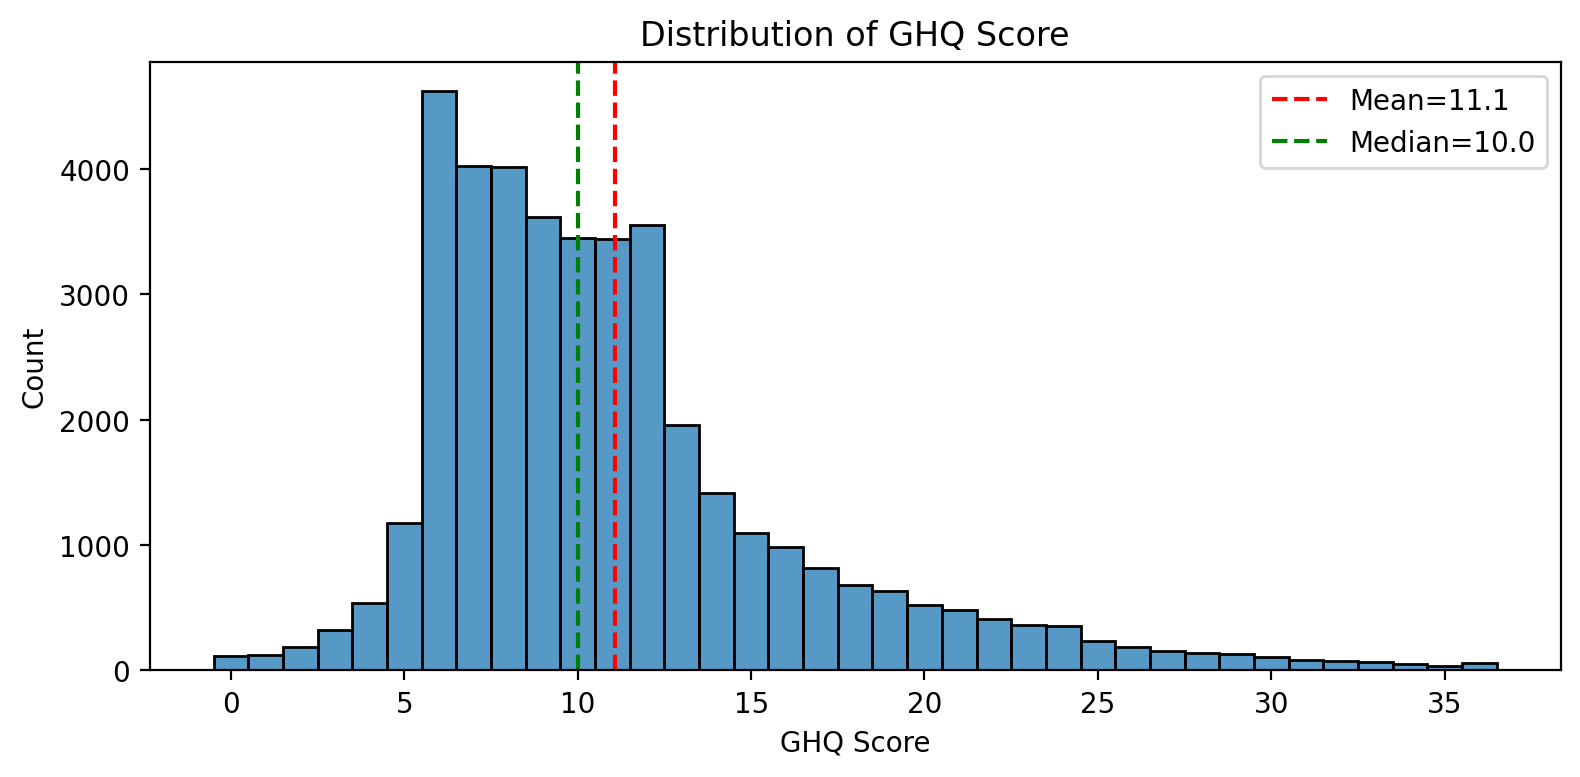

In [9]:
# Histogram of Y_processed (GHQ score)
bins = np.arange(Y_processed.min() - 0.5, Y_processed.max() + 1.5, 1)
plt.figure(figsize=(8, 4))
sns.histplot(Y_processed, bins=bins, stat="count", kde=False, color='C0')
plt.axvline(Y_processed.mean(), color="red", linestyle="--", label=f"Mean={Y_processed.mean():.1f}")
plt.axvline(Y_processed.median(), color="green", linestyle="--", label=f"Median={Y_processed.median():.1f}")
plt.title('Distribution of GHQ Score')
plt.xlabel('GHQ Score')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
print("Skewness: %f" %Y_processed.skew())
print("Kurtosis: %f" %Y_processed.kurt())


Skewness: 1.454642
Kurtosis: 2.651180


## Visualising the data

### Univariate analysis

Age distribution

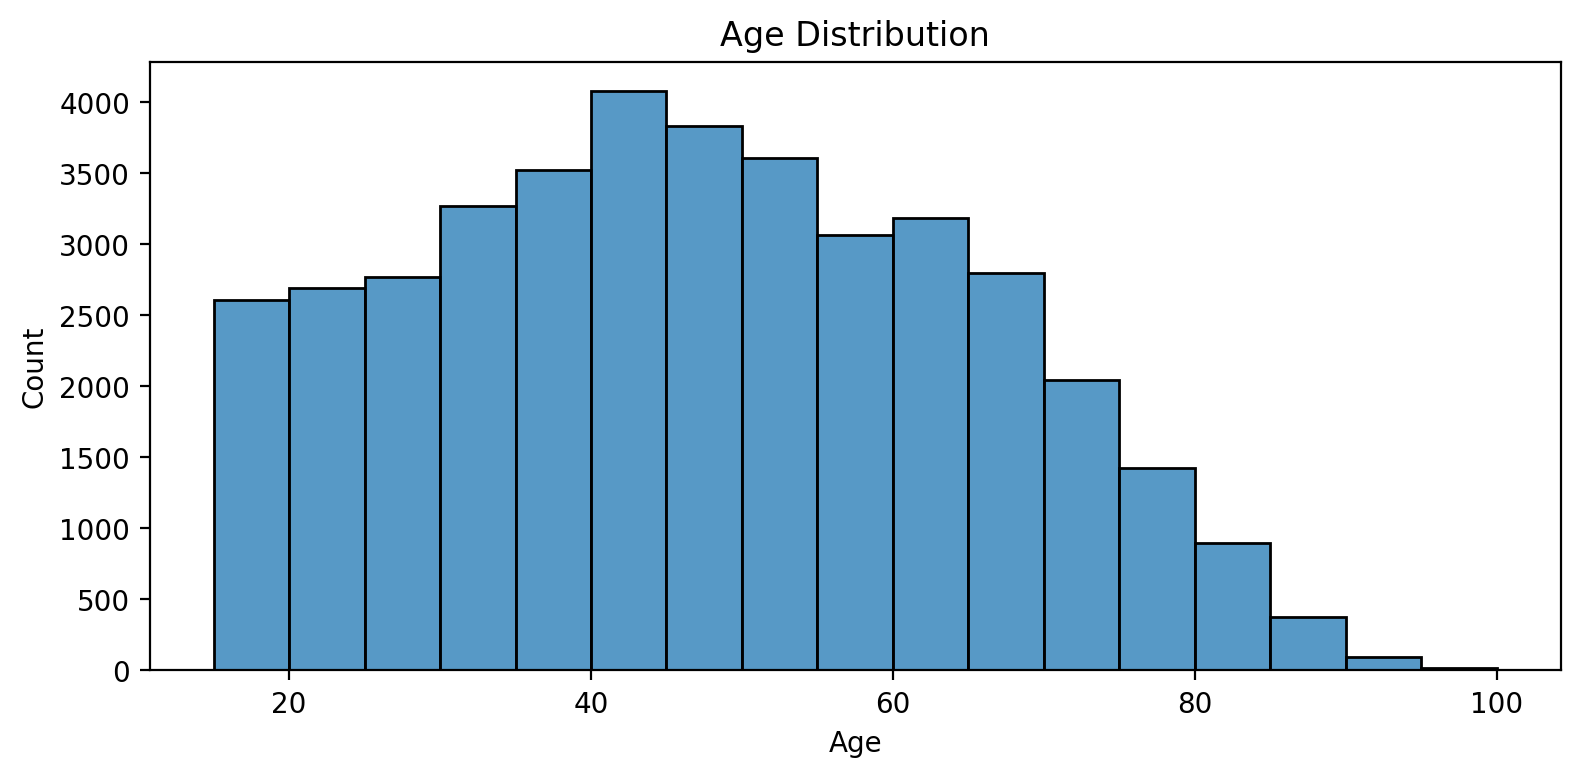

In [15]:

col = 'age_dv'
age_min = X[col].min()
age_max = X[col].max()

# bins of width 5, starting from the min value
bins = np.arange(age_min, age_max + 5, 5)

plt.figure(figsize=(8, 4))
sns.histplot(X[col], bins=bins, kde=False, color='C0')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Income

Sex

Social cohesion (informal institutions)

Location

Do a bunch of visualisations of single variables, then bivariate analysis (scatterplots, boxplots). Then I can start thinking about multi-variate analysis (correlation matrix, pairplot, etc).

## Regression models

In [12]:
# Lasso regression with cross-validation

from sklearn.linear_model import LassoCV
import pandas as pd
import numpy as np

# ---- config ---------------------------------------------------------------
CONTINUOUS = ['nbrsnci_dv', 'age_dv', 'fimnnet_dv', 'fihhmnnet1_dv', 'houscost1_dv']

def parse_dummy(colname: str):
    """
    If column is a dummy like 'jbstat_8', return (base_var, 8) else (None, None).
    Uses rsplit so bases with underscores still work.
    """
    if '_' not in colname:
        return None, None
    base, suffix = colname.rsplit('_', 1)
    return (base, int(suffix)) if suffix.lstrip('-').isdigit() else (None, None)

def value_label_for(base_var: str, code: int, meta):
    """
    meta.variable_to_label maps var -> labelset name
    meta.value_labels maps labelset name -> {code: label}
    """
    labelset = meta.variable_to_label.get(base_var)
    if not labelset:
        return None
    return meta.value_labels.get(labelset, {}).get(code)

def var_label(var: str, meta):
    """Human label for a column, including category if it’s a dummy."""
    base, code = parse_dummy(var)
    if base is None:  # continuous or already-binary (0/1) variable
        return meta.column_names_to_labels.get(var, var)

    base_label = meta.column_names_to_labels.get(base, base)
    cat_label = value_label_for(base, code, meta)
    if cat_label is None:
        cat_label = str(code)
    return f"{base_label}: {cat_label}"

def category_only(var: str, meta):
    """Category text for the 'Category' column; empty for non-dummies."""
    base, code = parse_dummy(var)
    if base is None:
        return ""
    cat_label = value_label_for(base, code, meta)
    return cat_label if cat_label is not None else f"Category {code}"

# ---- fit model ------------------------------------------------------------
alphas = np.logspace(-4, 0, 100)  # Range of alpha values to try
lasso = LassoCV(cv=5, random_state=0, alphas=alphas)
lasso.fit(X_processed, Y_processed)

# ---- build coefficient table ---------------------------------------------
coef_df = pd.DataFrame({
    "Variable": X_processed.columns,
    "Coefficient": lasso.coef_
})
coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
coef_df["Label"]    = coef_df["Variable"].apply(lambda v: var_label(v, meta))
coef_df["Category"] = coef_df["Variable"].apply(lambda v: category_only(v, meta))

# keep only non-zeros (Lasso makes some exactly zero)
non_zero = coef_df.loc[coef_df["Coefficient"] != 0].sort_values("Abs_Coefficient", ascending=False).reset_index(drop=True)

print(f"Number of non-zero coefficients: {len(non_zero)}")
display_cols = ["Variable", "Coefficient", "Label", "Category"]
non_zero[display_cols].head(60)



Number of non-zero coefficients: 54


,Variable,Coefficient,Label,Category
0,jbstat_8,5.254032,Current economic activity: LT sick or disabled,LT sick or disabled
1,health,-2.271059,Long-standing illness or disability,
2,jbstat_3,2.167115,Current economic activity: unemployed,unemployed
3,sex_dv,1.175816,"Sex, derived",
4,ethn_dv_16,-1.095527,Ethnic group (derived from multiple sources): ...,any other black background
5,marstat_dv_5,1.043533,Harmonised de facto marital status: Separated ...,Separated (incl. from civil partner)
6,nbrsnci_dv,-0.988343,"Buckner's Neighbourhood Cohesion Instrument, s...",
7,ethn_dv_10,0.934207,Ethnic group (derived from multiple sources): ...,pakistani
8,jbstat_11,-0.903107,Current economic activity: On apprenticeship,On apprenticeship
9,jbstat_6,0.875061,Current economic activity: Family care or home,Family care or home


In [13]:
# Run standard linear regression and show coefficients with p-values, sorted by absolute coefficient

X_sm = sm.add_constant(X_processed)
model = sm.OLS(Y_processed, X_sm).fit()
results_summary = model.summary2().tables[1]

results_summary = results_summary.rename(columns={"Coef.": "Coefficient", "P>|t|": "P-value"})
results_summary = results_summary.reset_index().rename(columns={"index": "Variable"})
results_summary["Abs_Coefficient"] = results_summary["Coefficient"].abs()
results_summary = results_summary.sort_values(by="Abs_Coefficient", ascending=False)

results_summary[["Variable", "Coefficient", "P-value"]].head(20)

,Variable,Coefficient,P-value
0,const,8.891989,8.079681e-02
48,jbstat_8,5.260316,1.476005e-193
40,marstat_dv_5,3.787790,4.569957e-01
39,marstat_dv_4,3.229065,5.258352e-01
38,marstat_dv_3,2.852419,5.752536e-01
36,marstat_dv_1,2.716117,5.935514e-01
37,marstat_dv_2,2.632638,6.049817e-01
41,marstat_dv_6,2.517108,6.208548e-01
8,health,-2.271741,0.000000e+00
43,jbstat_3,2.171050,6.277975e-47
